# Decoding from a CEBRA embedding

In this notebook, we show how to:

- decode labels from a CEBRA embedding.
- evaluate and compare the decoding performances for embeddings obtained from different hypotheses.

It is based on what was presented in [Figure 2.d.](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) of Schneider, Lee, Mathis.

**Install note**
- Be sure you have cebra, and the demo dependencies, installed to use this notebook

In [1]:
!pip install --pre 'cebra[datasets,demos]'

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
import cebra.datasets
from cebra import CEBRA

import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, GridSearchCV

In [3]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    corr = pearsonr(y_true.flatten(), y_pred.flatten())[0]
    return r2, corr

def continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]

    train_K, test_K = len(train_X), len(test_X)
    _, C, T = train_X.shape
    if time_independent:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
        train_Y = train_Y.reshape((-1))
        test_Y = test_Y.reshape((-1))
        if verbose:
            print("time-independent:")
    else:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, T*C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, T*C))
        if verbose:
            print("time-dependent:")

    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)

    if time_independent:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    else:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)

    if verbose:
        print(f"r2: {r2:.3f} corr: {corr:.3f}")

    return pred_Y, [r2, corr]

def sliding_window_over_time(data, half_window_size=3):

    window_size = 2*half_window_size + 1

    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - 2*half_window_size, window_size
        ))
        for t in range(n_t_bins - 2*half_window_size):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t + d]
            data_window[:,:,t] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        max_len = n_t_bins - 2*half_window_size
        data_window = np.zeros((n_trials, max_len, window_size))
        for t in range(max_len):
            data_window[:,t] = data[:,t:t+window_size]
        data_window = data_window[:,:,half_window_size]
    return data_window

def sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]

    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape

    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))

    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)

    r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    if verbose:
        print("sliding-window:")
        print(f"r2: {r2:.3f} corr: {corr:.3f}")

    return pred_Y, [r2, corr]

## Load the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/ibl_neural_latent_benchmark/

/content/drive/MyDrive/ibl_neural_latent_benchmark


In [6]:
neural_data = np.load("neural_data.npy", allow_pickle=True).item()
behavior_data = np.load("behavior_data.npy", allow_pickle=True).item()
print(neural_data.keys())
print(behavior_data.keys())

dict_keys(['po', 'lp', 'dg', 'ca1', 'vis'])
dict_keys(['wheel_speed', 'motion_energy', 'pupil_diameter', 'paw_speed'])


In [7]:
X, Y = neural_data["po"], behavior_data["motion_energy"]
K, C, T = X.shape
print(X.shape)
print(Y.shape)

(367, 159, 50)
(367, 50)


In [8]:
# data preprocessing
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)
smooth_Y = np.array([gaussian_filter1d(Y[k, :], 4) for k in range(K)])
norm_Y = smooth_Y / smooth_Y.max() # to prevent gradient explosion

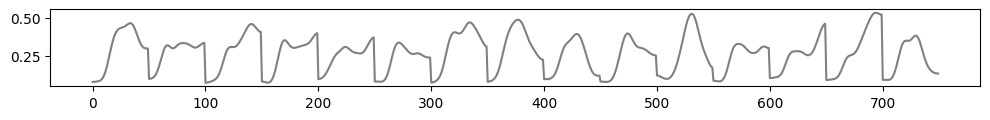

In [9]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[10:10+15].flatten(), c="gray")
plt.show()

**------------------- BEGINNING OF TRAINING SECTION -------------------**

## Train the models

*[This can be skipped if you already saved the models].*

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [21]:
seed = 666

kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for train, test in kf.split(X):
    pass
print(test)

[  2   9  16  24  42  45  46  51  57  60  63  69  70  77  80  83  86  88
  91  99 100 102 103 107 112 122 126 139 141 142 147 148 151 155 156 161
 164 166 168 174 175 192 204 210 212 219 222 223 225 236 255 261 270 276
 277 282 283 290 292 294 295 301 318 322 325 328 329 333 338 342 348 355
 361]


In [22]:
cebra_X = smooth_X.transpose(0, -1, 1)
neural_train, neural_test, label_train, label_test = cebra_X[train], cebra_X[test], norm_Y[train], norm_Y[test]
neural_train = neural_train.reshape(-1, C)
neural_test = neural_test.reshape(-1, C)
label_train = label_train.flatten().reshape(-1,1)
label_test = label_test.flatten().reshape(-1,1)
print(neural_train.shape)
print(label_train.shape)

(14700, 159)
(14700, 1)


In [31]:
max_iterations = 10000 #default is 5000.
output_dimension = 10 #here, we set as a variable for hypothesis testing below.

### Train CEBRA-Behavior with position, or direction, and/or both variables

In [32]:
cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=output_dimension,
                    max_iterations=max_iterations,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

In [33]:
cebra_model.fit(neural_train, label_train[:,0])
cebra_model.save("cebra_model.pt")

pos: -0.5345 neg:  6.4819 total:  5.9474 temperature:  1.0000: 100%|██████████| 10000/10000 [02:00<00:00, 82.85it/s]


**------------------- END OF TRAINING SECTION -------------------**

## Load the models and get the corresponding embeddings

In [34]:
cebra_model = cebra.CEBRA.load("cebra_model.pt")
cebra_latents = cebra_model.transform(cebra_X.reshape(-1, C)).reshape(K,T,output_dimension)

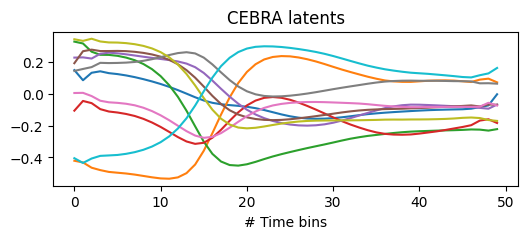

In [35]:
plt.figure(figsize=(6,2))
plt.plot(cebra_latents.mean(0))
plt.title("CEBRA latents")
plt.xlabel("# Time bins")
plt.show()

## Decode the labels from the embeddings


In [36]:
best_lag = 2

In [37]:
train_X, test_X = cebra_latents.transpose(0,-1,1)[train], cebra_latents.transpose(0,-1,1)[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.719 corr: 0.855
time-dependent:
r2: 0.753 corr: 0.870


In [38]:
window_X = sliding_window_over_time(cebra_latents.transpose(0,-1,1), half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.727 corr: 0.860


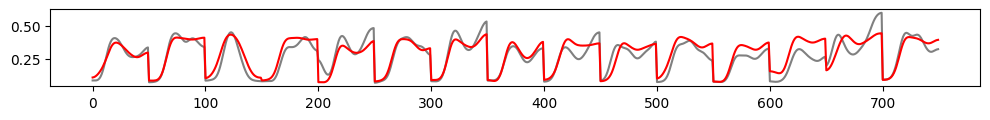

In [39]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()